In [1]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import sklearn.feature_extraction.text as sk_text
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import activations as activations

In [2]:
review_json_path = 'data/yelp_academic_dataset_review.json'

In [3]:
business_json_path = 'data/yelp_academic_dataset_business.json'
business_dataset = pd.read_json(business_json_path, lines=True)

In [4]:
drop_columns = ['hours','is_open','latitude','longitude','postal_code','attributes','address',
               'city','state','categories']
business_dataset = business_dataset.drop(drop_columns, axis=1)

In [5]:
business_dataset.drop(business_dataset.index[business_dataset['review_count'] < 20], inplace = True)

In [6]:
#trying to open review dataset crashes my notebook so split into chunks
size = 1000000
review_dataset = pd.read_json(review_json_path, lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=size)

In [7]:
chunk_list = []
for chunk_review in review_dataset:
    chunk_review = chunk_review.drop(['review_id','useful','funny','cool','date'], axis=1)
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    chunk_merged = pd.merge(business_dataset, chunk_review, on='business_id', how='inner')
    print(f"{chunk_merged.shape[0]} out of {size:,} related reviews")
    chunk_list.append(chunk_merged)
merged_dataset = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

899414 out of 1,000,000 related reviews
899707 out of 1,000,000 related reviews
901146 out of 1,000,000 related reviews
899750 out of 1,000,000 related reviews
894308 out of 1,000,000 related reviews
893526 out of 1,000,000 related reviews
899049 out of 1,000,000 related reviews
900048 out of 1,000,000 related reviews
565667 out of 1,000,000 related reviews


In [8]:
merged_dataset[0:5] 

,business_id,name,stars,review_count,user_id,review_stars,text
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,4.0,86,93z0yh-sUpGZS-cSKu6xxA,5,Stopped in on a busy Friday night. Despite the...
1,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,4.0,86,Q_CZIvnsDHjpls-EPzzG7Q,2,Went there about 1 PM on a Monday. It wasn't ...
2,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,4.0,86,rqxTSFFj5fZNmabY1fmTlw,5,This was the place the be on Friday Night! If ...
3,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,4.0,86,vNPxlt5f50q0e2nVAScW3Q,4,Went to this place with my family over the wee...
4,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,4.0,86,eXRC79iX60xwA1UuGRuWNg,4,"Stopped on a midweek afternoon, and so glad th..."


In [9]:
grouped_reviews = merged_dataset.groupby('business_id')['text'].sum()  #group reviews by business ID
reviews_ready_for_sklearn = pd.DataFrame({'business_id': grouped_reviews.index, 'all_reviews': grouped_reviews.values})

In [10]:
grouped_stars = merged_dataset.groupby('business_id')['stars'].mean()  #group stars by business ID
grouped_stars_df = pd.DataFrame({'business_id': grouped_stars.index, 'review_stars': grouped_stars.values})

In [11]:
grouped_stars_df[0:5]

,business_id,review_stars
0,--164t1nclzzmca7eDiJMw,4.0
1,--6COJIAjkQwSUZci_4PJQ,4.0
2,--JKSSgnfoOjVDFGv692BA,4.0
3,--Q3mAcX9t63f7Xcbn7LVA,4.5
4,--TEGvhgrXwHnRjiFbK08Q,5.0


In [12]:
reviews_ready_for_sklearn[0:5]

,business_id,all_reviews
0,--164t1nclzzmca7eDiJMw,"Banh mi was pretty weak.Incredibly good food, ..."
1,--6COJIAjkQwSUZci_4PJQ,Casually comfortable and pleasant environment ...
2,--JKSSgnfoOjVDFGv692BA,Fast service. $15 bucks and I was outta there....
3,--Q3mAcX9t63f7Xcbn7LVA,this place was truly amazing place!from the be...
4,--TEGvhgrXwHnRjiFbK08Q,I have been getting facials from Danica for 7+...


In [13]:
rows, cols = reviews_ready_for_sklearn.shape
text_list = []
for r in range(rows):
    text_list.append(reviews_ready_for_sklearn.iat[r, 1]) #prepare a list of documents for TFidf

In [14]:
vectorizer = sk_text.TfidfVectorizer(min_df=18000, max_df=50000, max_features=20000)  #choose terms that appear in more than 18,000 documents, less than 50,000 and max_features 20000
matrix = vectorizer.fit_transform(text_list)

In [25]:
tfidf_data = matrix.toarray()

In [16]:
input_data = grouped_stars_df.to_numpy()  

In [17]:
input_data = np.concatenate((input_data, tfidf_data), axis=1)  #concatenate the businesses' star ratings with their tf-idf values

In [18]:
input_data = pd.DataFrame(input_data)

In [19]:
input_data = input_data.drop([0], axis=1)  #drop the business_id column for processing

In [20]:
input_data.rename(columns = {1:'stars'}, inplace = True)

In [21]:
input_data[0:10]

,stars,2,3,4,5,6,7,8,9,10,...,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190
0,4.0,0.008216,0.007986,0.0,0.003758,0.0,0.005201,0.0,0.00528,0.0,...,0.007909,0.015021,0.031711,0.034006,0.004341,0.008225,0.007371,0.036326,0.013117,0.009529
1,4.0,0.006793,0.0,0.0,0.0,0.004397,0.0,0.0,0.0,0.004722,...,0.003269,0.0,0.003746,0.008435,0.0,0.0,0.009142,0.004291,0.018076,0.0
2,4.0,0.030458,0.0,0.0,0.055731,0.0,0.0,0.0,0.0,0.0,...,0.029318,0.0,0.033587,0.050426,0.032182,0.0,0.0,0.0,0.0,0.0
3,4.5,0.026048,0.0,0.0,0.017873,0.0,0.008244,0.0,0.0,0.009054,...,0.018804,0.0,0.007181,0.005391,0.006881,0.0,0.005842,0.008226,0.013862,0.007552
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.034291,0.0,0.0,0.05898,0.0,0.035664,0.0,0.0,0.0,0.0
5,4.5,0.0,0.0,0.021558,0.0,0.0,0.0,0.0,0.0,0.0,...,0.020313,0.0,0.0,0.069877,0.0,0.0,0.018933,0.0,0.0,0.0
6,4.5,0.006679,0.006874,0.002007,0.006829,0.002543,0.002487,0.002548,0.002525,0.001639,...,0.004538,0.002873,0.006066,0.018213,0.00083,0.004326,0.00987,0.013897,0.012127,0.001823
7,4.0,0.011293,0.0,0.0,0.020663,0.0,0.0,0.0,0.014514,0.0,...,0.0,0.0,0.0,0.009348,0.0,0.0,0.0,0.0,0.024039,0.0
8,4.5,0.001316,0.005114,0.008063,0.016849,0.0,0.011659,0.013652,0.003381,0.001829,...,0.002533,0.001603,0.002901,0.005445,0.00278,0.002634,0.008262,0.0,0.004201,0.0
9,3.0,0.022733,0.0,0.0,0.010399,0.0,0.043172,0.0,0.0,0.0,...,0.021882,0.013854,0.0,0.018818,0.01201,0.022758,0.010198,0.0,0.0,0.026365


In [22]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    b = plt.plot(t['pred'].tolist(),label='prediction')
    a = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

In [23]:
rows, cols = input_data.shape
for c in range(2, cols):
    encode_numeric_zscore(input_data, c)  #encode each column of tf-idf matrix to z-score

input_data[0:10]

,stars,2,3,4,5,6,7,8,9,10,...,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190
0,4.0,-0.133299,-0.101081,-0.570097,-0.44858,-0.410866,0.002017,-0.391616,-0.014397,-0.360954,...,-0.046964,0.913725,2.044141,0.848396,-0.235508,-0.05802,-0.207726,1.442216,0.073316,0.009529
1,4.0,-0.205816,-0.626291,-0.570097,-0.679695,-0.034099,-0.440019,-0.391616,-0.390184,0.02151,...,-0.42533,-0.460756,-0.239591,-0.337698,-0.580278,-0.552096,-0.076774,-0.157647,0.341016,0.0
2,4.0,1.000281,-0.626291,-0.570097,2.747403,-0.410866,-0.440019,-0.391616,-0.390184,-0.360954,...,1.699203,-0.460756,2.197393,1.610022,1.975939,-0.552096,-0.752833,-0.371928,-0.63482,0.0
3,4.5,0.775502,-0.626291,-0.570097,0.419373,-0.410866,0.260681,-0.391616,-0.390184,0.372298,...,0.841718,-0.460756,0.040954,-0.478918,-0.03376,-0.552096,-0.320791,0.038888,0.113521,0.007552
4,5.0,-0.552038,-0.626291,-0.570097,-0.679695,-0.410866,-0.440019,-0.391616,-0.390184,-0.360954,...,2.104831,-0.460756,-0.545469,2.006793,-0.580278,1.590209,-0.752833,-0.371928,-0.63482,0.0
5,4.5,-0.552038,-0.626291,0.830744,-0.679695,-0.410866,-0.440019,-0.391616,-0.390184,-0.360954,...,0.964769,-0.460756,-0.545469,2.512207,-0.580278,-0.552096,0.647285,-0.371928,-0.63482,0.0
6,4.5,-0.211634,-0.174219,-0.439696,-0.259728,-0.192962,-0.228641,-0.190369,-0.210485,-0.228235,...,-0.321854,-0.197849,-0.050136,0.115836,-0.514332,-0.292206,-0.022968,0.322079,0.019855,0.001823
7,4.0,0.02352,-0.626291,-0.570097,0.59098,-0.410866,-0.440019,-0.391616,0.642857,-0.360954,...,-0.69199,-0.460756,-0.545469,-0.295339,-0.580278,-0.552096,-0.752833,-0.371928,0.662959,0.0
8,4.5,-0.484991,-0.289916,-0.046148,0.356443,-0.410866,0.55085,0.68653,-0.149508,-0.212825,...,-0.485434,-0.31404,-0.308535,-0.476397,-0.359467,-0.393879,-0.141876,-0.371928,-0.408054,0.0
9,3.0,0.606569,-0.626291,-0.570097,-0.040223,-0.410866,3.229183,-0.391616,-0.390184,-0.360954,...,1.092728,0.806926,-0.545469,0.143919,0.373666,0.81496,0.001295,-0.371928,-0.63482,0.026365


Epoch 1/1000
1712/1712 - 2s - loss: 0.2786 - val_loss: 0.1214
Epoch 2/1000
1712/1712 - 2s - loss: 0.1052 - val_loss: 0.1028
Epoch 3/1000
1712/1712 - 2s - loss: 0.0924 - val_loss: 0.0982
Epoch 4/1000
1712/1712 - 2s - loss: 0.0862 - val_loss: 0.0956
Epoch 5/1000
1712/1712 - 2s - loss: 0.0824 - val_loss: 0.0941
Epoch 6/1000
1712/1712 - 2s - loss: 0.0793 - val_loss: 0.0958
Epoch 7/1000
1712/1712 - 2s - loss: 0.0771 - val_loss: 0.0926
Epoch 8/1000
1712/1712 - 2s - loss: 0.0754 - val_loss: 0.0895
Epoch 9/1000
1712/1712 - 2s - loss: 0.0739 - val_loss: 0.0883
Epoch 10/1000
1712/1712 - 2s - loss: 0.0726 - val_loss: 0.0892
Epoch 11/1000
1712/1712 - 2s - loss: 0.0715 - val_loss: 0.0887
Epoch 12/1000
1712/1712 - 2s - loss: 0.0705 - val_loss: 0.0881
Epoch 13/1000
1712/1712 - 2s - loss: 0.0695 - val_loss: 0.0889
Epoch 14/1000
1712/1712 - 2s - loss: 0.0687 - val_loss: 0.0879
Epoch 00014: early stopping
Score (RMSE): 0.2964675724506378


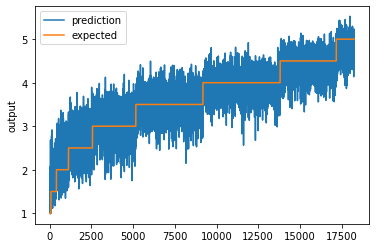

In [24]:
#training
x,y = to_xy(input_data, 'stars')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)


model = Sequential()
model.add(Dense(15, input_dim=x.shape[1], activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(5, input_dim=x.shape[1], activation='relu'))
model.add(Dense(1, activation='relu'))


model.compile(loss='mean_squared_error', optimizer='SGD')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)